In [116]:
import os
import sys
import time
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
from spectrome import Brain, path, functions
from SGMfns import MEGPSD2SF, sgm

In [2]:
from spectrome import Brain, path, functions
from tqdm import trange, tqdm

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sklearn.preprocessing import minmax_scale

import numpy as np
import xarray as xr
from easydict import EasyDict as edict
from pathlib import Path
import pickle
import scipy

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [114]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

### Some functions

In [115]:
def mag2db(y):
    """Convert magnitude response to decibels for a simple array.

    Args:
        y (numpy array): Power spectrum, raw magnitude response.

    Returns:
        dby (numpy array): Power spectrum in dB

    """
    dby = 20 * np.log10(y)
    return dby

stdPSDFn = lambda x: (x- x.mean(axis=1).reshape(-1, 1))/x.std(axis=1).reshape(-1, 1)
stdFn = lambda x: (x-x.mean())/x.std()
minmaxFn = lambda x: (x-x.min())/(x.max()-x.min())

### Load real data PSD and brain

In [5]:
# Load data
ind_psd_xr = xr.open_dataarray('../data/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
freqs = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray('../data/individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values



data_dir = path.get_data_path()

In [6]:
# Get reorder indeix
# dk86.***.txt is the order for the MEG data
# DK68_labelorder.xlsx is the order for the template
dk_brainnet = pd.read_excel(Path(data_dir)/"DK68_labelorder.xlsx")
with open(Path(data_dir)/'dk86atlas_regions_python.txt') as f:
    dk_python = f.readlines()
    
brainnet_order = dk_brainnet["Order in Brainstorm"]
dk_python_renamed = []
brainnet_renamed = []

for i in range(len(dk_python)):
    sp1 = dk_python[i].split('=')
    sp2 = sp1[1].split('_')
    dk_python_renamed.append((sp2[0] + ' ' + sp2[1]).lower().strip())

for i in range(len(brainnet_order)):
    brainnet_renamed.append((brainnet_order[i].replace("'","")).lower())

d = {x: a for a, x in enumerate(dk_python_renamed[0:68])}
orderedind = np.array([d[x] for x in brainnet_renamed])

In [7]:
def reorderU(wU):
    wUreorder = wU.copy()
    wUreorder = wU[orderedind]
    return wUreorder

with open(Path(data_dir)/'BNVtemplate_DK68.txt', "r") as tf:
    DKtmplateRaw = tf.readlines()
DKtmplate = np.array([int(x.strip()) for x in DKtmplateRaw])

def U2BrainVec(wU):
    emVec = np.zeros_like(DKtmplate, dtype=np.float64)
    for idx in range(1, 69):
        emVec[DKtmplate==idx] = wU[idx-1]
    return emVec

### Set up Parameters

In [8]:
paras = edict()
paras.noiseSd = 0.2
paras.numPriorSps = int(1e5)
paras.path = Path("./mainResults")

paras.robustParas = edict()
paras.robustParas.numRep = 20
paras.robustParas.noiseSd = 0.2
paras.robustParas.numPriorSps = int(1e5)
paras.robustParas.path = Path(paras.path/"robustResults")

In [9]:
if not paras.path.exists():
    paras.path.mkdir()
if not paras.robustParas.path.exists():
    paras.robustParas.path.mkdir()

### Prepare for SBI

In [10]:
def network_transfer_local_alpha(C, D, parameters, w):
    """Network Transfer Function for spectral graph model.

    Args:
        brain (Brain): specific brain to calculate NTF
        parameters (dict): parameters for ntf. We shall keep this separate from Brain
        for now, as we want to change and update according to fitting.
        frequency (float): frequency at which to calculate NTF

    Returns:
        model_out (numpy asarray):  Each region's frequency response for
        the given frequency (w)
        frequency_response (numpy asarray):
        ev (numpy asarray): Eigen values
        Vv (numpy asarray): Eigen vectors

    """
    #C = brain.reducedConnectome
    #D = brain.distance_matrix

    
    parameters = np.asarray(parameters)
    tau_e = parameters[0]
    tau_i = parameters[1]
    tauC =  parameters[2]
    speed = parameters[3]
    alpha = parameters[4]
    gii =   parameters[5]  
    gei =   parameters[6]  
    gee = 1
    
    # Defining some other parameters used:
    zero_thr = 0.05

    # define sum of degrees for rows and columns for laplacian normalization
    rowdegree = np.transpose(np.sum(C, axis=1))
    coldegree = np.sum(C, axis=0)
    qind = rowdegree + coldegree < 0.2 * np.mean(rowdegree + coldegree)
    rowdegree[qind] = np.inf
    coldegree[qind] = np.inf

    nroi = C.shape[0]

    K = nroi

    Tau = 0.001 * D / speed
    Cc = C * np.exp(-1j * Tau * w)

    # Eigen Decomposition of Complex Laplacian Here
    L1 = np.identity(nroi)
    L2 = np.divide(1, np.sqrt(np.multiply(rowdegree, coldegree)) + np.spacing(1))
    L = L1 - alpha * np.matmul(np.diag(L2), Cc)

    d, v = np.linalg.eig(L)  
    eig_ind = np.argsort(np.abs(d))  # sorting in ascending order and absolute value
    eig_vec = v[:, eig_ind]  # re-indexing eigen vectors according to sorted index
    eig_val = d[eig_ind]  # re-indexing eigen values with same sorted index

    eigenvalues = np.transpose(eig_val)
    eigenvectors = eig_vec[:, 0:K]

#     # Cortical model
    Fe = np.divide(1 / tau_e ** 2, (1j * w + 1 / tau_e) ** 2)
    Fi = np.divide(1 / tau_i ** 2, (1j * w + 1 / tau_i) ** 2)
    FG = np.divide(1 / tauC ** 2, (1j * w + 1 / tauC) ** 2)

    Hed = (1 + (Fe * Fi * gei)/(tau_e * (1j * w + Fi * gii/tau_i)))/(1j * w + Fe * gee/tau_e + (Fe * Fi * gei)**2/(tau_e * tau_i * (1j * w + Fi * gii / tau_i)))
    
    Hid = (1 - (Fe * Fi * gei)/(tau_i * (1j * w + Fe * gee/tau_e)))/(1j * w + Fi * gii/tau_i + (Fe * Fi * gei)**2/(tau_e * tau_i * (1j * w + Fe * gee / tau_e)))

    Htotal = Hed + Hid


#     q1 = (1j * w + 1 / tau_e * Fe * eigenvalues)
    q1 = (1j * w + 1 / tauC * FG * eigenvalues)
    qthr = zero_thr * np.abs(q1[:]).max()
    magq1 = np.maximum(np.abs(q1), qthr)
    angq1 = np.angle(q1)
    q1 = np.multiply(magq1, np.exp(1j * angq1))
    frequency_response = np.divide(Htotal, q1)
    
    model_out = 0

    for k in range(K):
        model_out += (frequency_response[k]) * np.outer(eigenvectors[:, k], np.conjugate(eigenvectors[:, k])) 
    model_out2 = np.linalg.norm(model_out,axis=1)

    
    return model_out2, frequency_response, eigenvalues, eigenvectors


class sgm:
    def __init__(self, C, D, freqs, band="alpha"):
        self.freqs = freqs 
        self.C = C
        self.D = D
        if band == "alpha":
            self.freqband = np.where((freqs>=8) & (freqs<=12))[0]
        elif band == "beta":
            self.freqband = np.where((freqs>=13) & (freqs<=25))[0]
        else:
            self.freqband = np.arange(len(freqs))
            
    def run_local_coupling_forward(self, params):
        """run_forward. Function for running the forward model over the passed in range of frequencies,
        for the handed set of parameters (which must be passed in as a dictionary)
    
        Args:
            brain (Brain): An instance of the Brain class.
            #C = brain.reducedConnectome
            #D = brain.distance_matrix
            params (dict): Dictionary of a setting of parameters for the NTF model.
            freqs (array): Array of freqencies for which the model is to be calculated.
    
        Returns:
            array: Model values for each frequency, for each region of the brain, ordered as according to HCP
            (as in Brain class ordering).
    
        """
    
        eigenvalues = []
        eigenvectors = []
        frequency_response = []
        model_out = []
    
        for freq in self.freqs:
            w = 2 * np.pi * freq
            freq_model, freq_resp, eig_val, eig_vec = network_transfer_local_alpha(
                self.C, self.D, params, w
            )
            frequency_response.append(freq_resp)
            eigenvalues.append(eig_val)
            eigenvectors.append(eig_vec)
            model_out.append(freq_model)
    
        frequency_response = np.asarray(frequency_response)
        eigenvalues = np.asarray(eigenvalues)
        eigenvectors = np.asarray(eigenvectors)
        model_out = np.transpose(np.asarray(model_out))
        
        model_out_band = model_out[:68, self.freqband]
        model_out_band_sum = np.sum(model_out_band,axis = 1)
        model_out_band_sum_norm = model_out_band_sum/np.linalg.norm(model_out_band_sum) # spatial feature on the specific band
    
        return model_out, model_out_band_sum_norm, frequency_response, eigenvalues, eigenvectors

In [11]:
# calculate the spatial feature for MEG under the given band
def MEGPSD2SF(C, PSD, freqs, band="alpha", is_More=False):
    if band == "alpha":
        freqband = np.where((freqs>=8) & (freqs<=12))[0]
    elif band == "beta":
        freqband = np.where((freqs>=13) & (freqs<=25))[0]
    else:
        freqband = np.arange(len(freqs))
    
    summed_PSD = np.sum(PSD[:,freqband], axis = 1)
    summed_PSD = summed_PSD/np.linalg.norm(summed_PSD)

    w_spat = 10.0

    rowdegree = np.transpose(np.sum(C, axis=1))
    coldegree = np.sum(C, axis=0)
    qind = rowdegree + coldegree < 0.2 * np.mean(rowdegree + coldegree)
    rowdegree[qind] = np.inf
    coldegree[qind] = np.inf
    L2 = np.divide(1, np.sqrt(np.multiply(rowdegree, coldegree)) + np.spacing(1))
    Cc = np.matmul(np.diag(L2), C)
    
    C2 = Cc + w_spat*np.eye(86)
    rowdegree = np.transpose(np.sum(C2, axis=1))
    coldegree = np.sum(C2, axis=0)
    qind = rowdegree + coldegree < 0.2 * np.mean(rowdegree + coldegree)
    rowdegree[qind] = np.inf
    coldegree[qind] = np.inf
    L22 = np.divide(1, np.sqrt(np.multiply(rowdegree, coldegree)) + np.spacing(1))
    Cc2 = np.matmul(np.diag(L22), C2)    
    
    
    func1 = np.matmul(Cc2[0:68,0:68], summed_PSD) 
    if is_More:
        return func1, summed_PSD # first for analyse, second for plotting on brain
    else:
        return func1

In [12]:
def para2res(params):
    psd, spatialFs, _, _, _  = sgmmodel.run_local_coupling_forward(params)
    psdDB = mag2db(np.abs(psd))
    stdPsdDB = stdPSDFn(psdDB)
    stdSpatialFs = stdFn(spatialFs)
    return stdPsdDB, stdSpatialFs

def simulator(params):
    psd, sp = para2res(params)
    psd = psd[:68, :]
    #res = np.concatenate([psd.flatten(), sp])
    psdM = psd.mean(axis=0)
    res = np.concatenate([psdM, sp])
    noise =  np.random.randn(*res.shape)*paras.noiseSd
    return res + noise

In [13]:
#v_lower = 3.5-1.8
#v_upper = 3.5+1.8
#bnds = ((5.0,30.0), (5.0,200.0), (0.1,1.0), (v_lower,v_upper), (0.5,10.0), (0.5,10.0), (5.0,30.0))
#This is the order for the above bounds:  tau_e, tau_i, alpha, speed, gei, gii, tauC,

# taue, taui, tauC, speed, alpha, gii, gei
par_low = np.asarray([0.005,0.005,0.005,1.7,0.1,0.5,0.5])
par_high = np.asarray([0.03, 0.20, 0.03,5.3,  1, 10, 10])

### Robustness of parameter estimation

In [14]:
# obtain the brain
data_dir = path.get_data_path()
brain = Brain.Brain()
brain.add_connectome(data_dir)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

sgmmodel = sgm(brain.reducedConnectome, brain.distance_matrix, freqs)

In [15]:
prior = utils.BoxUniform(low=torch.as_tensor(par_low), high=torch.as_tensor(par_high))
# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

In [ ]:
for ix in range(paras.robustParas.numRep):
    theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=int(paras.robustParas.numPriorSps), num_workers=100)
    fname = f"./robustSps_{paras.robustParas.numPriorSps:.0f}_sd{paras.robustParas.noiseSd*100:.0f}_{ix+1}.pkl"
        
    inference = SNPE(prior=prior, density_estimator="mdn")
    density_estimator = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior(density_estimator)
    curRes = edict()
    curRes.theta = theta
    curRes.x = x
    curRes.posterior = posterior
    
    with open(paras.robustParas.path/fname, "wb") as f:
        pickle.dump(curRes, f)

In [16]:
fils = list(paras.robustParas.path.glob("robustSps_100000*.pkl"))
tmpSortFn = lambda p: int(p.stem.split("_")[-1])
sortedFils = sorted(fils, key=tmpSortFn)

In [18]:
for ixfil in tqdm(sortedFils[:]):
    with open(ixfil, "rb") as f:
        curRes = pickle.load(f)
        
    ix = tmpSortFn(ixfil)
    #if ix != 12:
    #    continue 
    postSpss = []
    for iy in range(ind_psd.shape[-1]):
        curC = ind_conn[:, :, iy]
        curBrain = Brain.Brain()
        curBrain.add_connectome(data_dir) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
        curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
        curBrain.connectome = curC# re-assign connectome to individual connectome
        curBrain.bi_symmetric_c()
        curBrain.reduce_extreme_dir()
        
        sp = MEGPSD2SF(curBrain.reducedConnectome, ind_psd[:, :, iy], freqs, band="alpha")
        stdSp = stdFn(sp)
        stdPsd = stdPSDFn(mag2db(ind_psd[:, :, iy])).mean(axis=0)
        curX = torch.Tensor(np.concatenate([stdPsd, stdSp]))
        postSps = curRes.posterior.sample((10000, ), x=curX, max_sampling_batch_size=100000)
        postSpss.append(postSps)
        
    
    curRes.postSpss = postSpss
    with open(ixfil, "wb") as f:
        pickle.dump(curRes, f)

  0%|                                                                                                          | 0/20 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/home/hujin/.local/lib/python3.9/site-packages/pyknos/mdn/mdn.py:279: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  zero_mean_samples, _ = torch.triangular_solve(


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9998 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

  5%|████▉                                                                                             | 1/20 [00:19<06:17, 19.86s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 10%|█████████▊                                                                                        | 2/20 [00:21<02:48,  9.39s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 15%|██████████████▋                                                                                   | 3/20 [00:23<01:42,  6.01s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 20%|███████████████████▌                                                                              | 4/20 [00:26<01:11,  4.47s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 25%|████████████████████████▌                                                                         | 5/20 [00:27<00:53,  3.56s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 30%|█████████████████████████████▍                                                                    | 6/20 [00:29<00:42,  3.03s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 35%|██████████████████████████████████▎                                                               | 7/20 [00:32<00:35,  2.74s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 40%|███████████████████████████████████████▏                                                          | 8/20 [00:34<00:30,  2.52s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9969 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 45%|████████████████████████████████████████████                                                      | 9/20 [00:37<00:32,  2.93s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████▌                                                | 10/20 [00:40<00:26,  2.66s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████▎                                           | 11/20 [00:42<00:22,  2.46s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9947 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 60%|██████████████████████████████████████████████████████████▏                                      | 12/20 [00:44<00:20,  2.52s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 65%|███████████████████████████████████████████████████████████████                                  | 13/20 [00:46<00:16,  2.41s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████▉                             | 14/20 [00:48<00:13,  2.29s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████▊                        | 15/20 [00:51<00:11,  2.26s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 16/20 [00:53<00:08,  2.24s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▍              | 17/20 [00:55<00:06,  2.23s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9921 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 18/20 [00:58<00:04,  2.35s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▏    | 19/20 [01:00<00:02,  2.37s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:02<00:00,  3.14s/it]


#### Point estimates of the parameters

In [19]:
estParass = []
for ixfil in tqdm(sortedFils[:]):
    with open(ixfil, "rb") as f:
        curRes = pickle.load(f)
    estParass.append(np.array([np.median(postSps.numpy(), axis=0) for postSps in curRes.postSpss]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.36it/s]


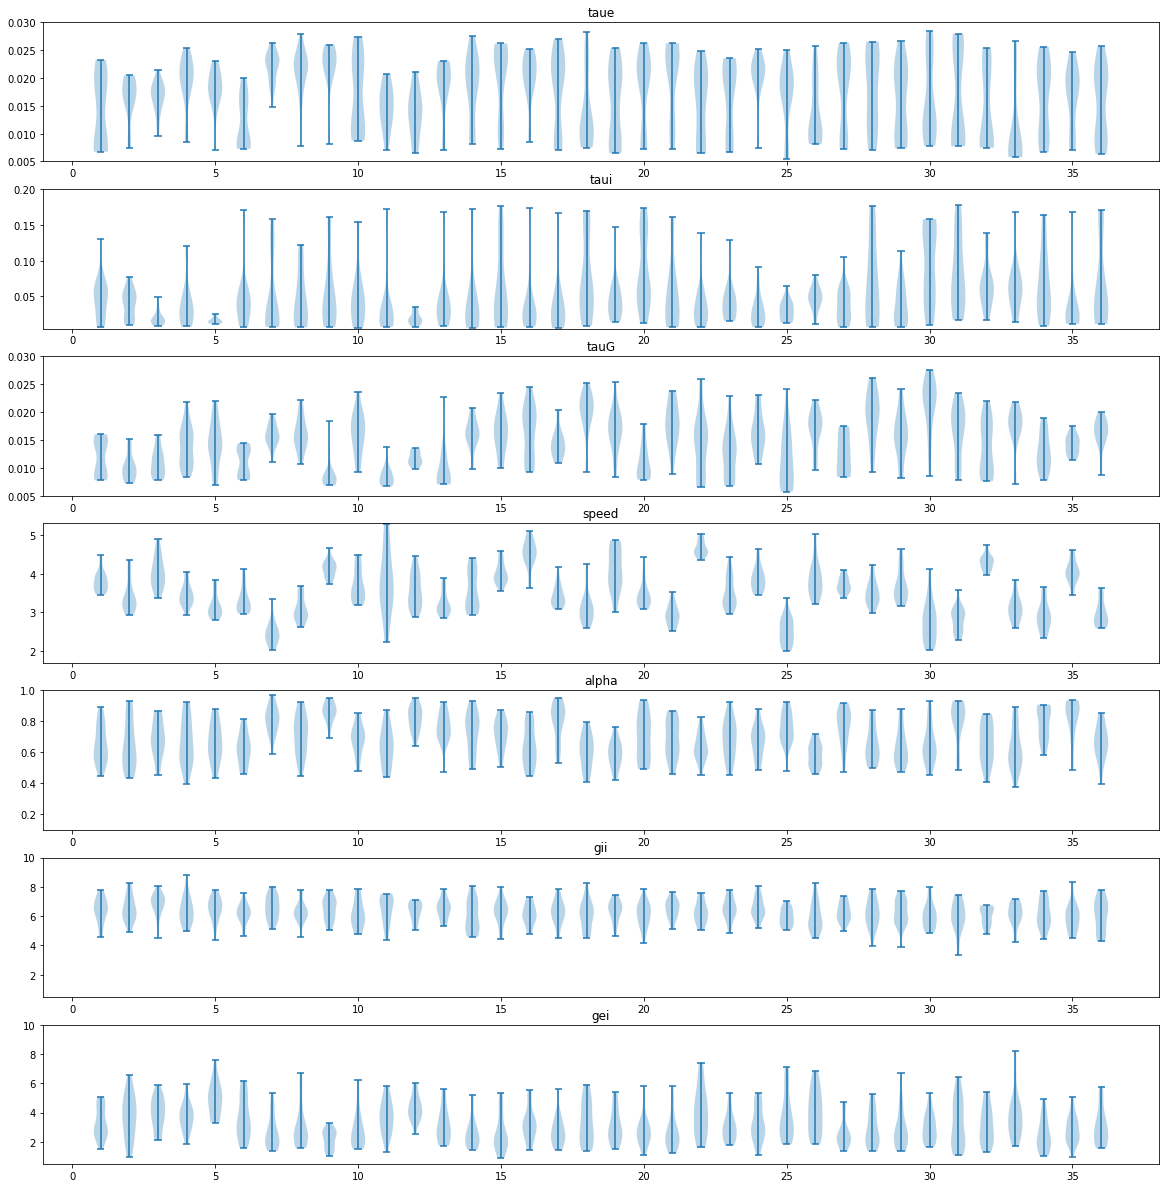

In [20]:
plotLimits = np.array([par_low, par_high]).T
labels=['taue','taui','tauG','speed','alpha','gii','gei']
estParass = np.array(estParass)
plt.figure(figsize=[20, 21])
for ix in range(7):
    plt.subplot(7, 1, ix+1)
    plt.violinplot(estParass[:, :, ix])
    plt.ylim(plotLimits[ix, :])
    plt.title(labels[ix])

In [ ]:
# taue, taui, tauC, speed, alpha, gii, gei
_ = analysis.pairplot(curRes.postSpss[0], limits=plotLimits, labels=['taue','taui','tauG','speed','alpha','gii','gei'], figsize=(8,8))

#### Spectral estimation

In [21]:
# the estimated spatial feature from MEG
MEGSPs = []
MEGSPRaws = []
for ix in trange(36):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    
    curMEGSP, curMEGSPRaw = MEGPSD2SF(curBrain.reducedConnectome, ind_psd[:, :, ix], freqs, is_More=True)
    MEGSPs.append(curMEGSP)
    MEGSPRaws.append(curMEGSPRaw)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 49.57it/s]


In [ ]:
# the estimated PSD and spatial feature from SGM 
# for each iteration, we have 20 in total 
for ixfil in tqdm(sortedFils[:]):
    sgmPSDs = []
    sgmSPs = []
    with open(ixfil, "rb") as f:
        curRes = pickle.load(f)
        
    curEstParas = np.array([np.median(i.numpy(), axis=0) for i in curRes.postSpss])
    for ix in trange(36):
        curParas = curEstParas[ix, :]
        curC = ind_conn[:, :, ix]
        curBrain = Brain.Brain()
        curBrain.add_connectome(data_dir) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
        curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
        curBrain.connectome = curC# re-assign connectome to individual connectome
        curBrain.bi_symmetric_c()
        curBrain.reduce_extreme_dir()
        
        curSgmModel = sgm(curBrain.reducedConnectome, curBrain.distance_matrix, freqs)
        curPSD, curSP, _, _, _  = curSgmModel.run_local_coupling_forward(curParas)
        curPSD = curPSD[:68, :]
        curPSD = stdPSDFn(mag2db(np.abs(curPSD)))
        
        sgmPSDs.append(curPSD)
        sgmSPs.append(curSP)
    
    
    
    curRes.sgmPSDs = sgmPSDs
    curRes.sgmSPs = sgmSPs
    with open(ixfil, "wb") as f:
        pickle.dump(curRes, f)

In [48]:
corrs = []
PSDs = []
MEGPSDMean = np.mean([stdPSDFn(mag2db(ind_psd[:, :, ix])).mean(axis=0) for ix in range(36)], axis=0)
for ix in trange(20):
    with open(sortedFils[ix], "rb") as f:
        curRes = pickle.load(f)
    curPSD = np.array(curRes.sgmPSDs).mean(axis=1).mean(axis=0)
    cor = scipy.stats.pearsonr(stdFn(MEGPSDMean), stdFn(curPSD))[0]
    corrs.append(cor)
    PSDs.append(curPSD)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.32it/s]


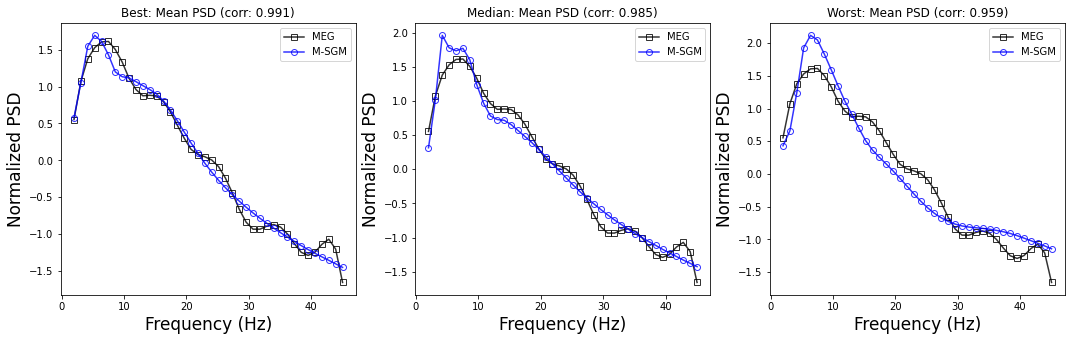

In [56]:
corrs = np.array(corrs)
bestId = np.argmax(corrs)
worstId = np.argmin(corrs)
medId = np.argmin(np.abs(corrs-np.median(corrs)))
titles = ["Best", "Median", "Worst"]
plt.figure(figsize=[18, 5])
for ix, curId in enumerate([bestId, medId, worstId]):
    plt.subplot(1, 3, ix+1)
    plt.title(f"{titles[ix]}: Mean PSD (corr: {corrs[curId]:.3f})")
    plt.plot(freqs, stdFn(MEGPSDMean), linestyle = '-',marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
    plt.plot(freqs, stdFn(PSDs[curId]), linestyle = '-',marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
    plt.xlabel('Frequency (Hz)', fontsize = 17)
    plt.legend()
    plt.ylabel('Normalized PSD', fontsize = 17)

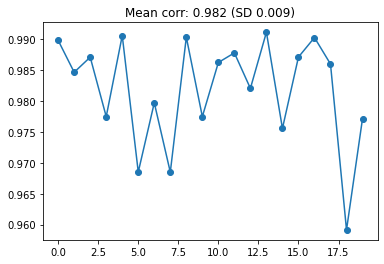

In [65]:
plt.title(f"Mean corr: {corrs.mean():.3f} (SD {corrs.std():.3f})")
plt.plot(corrs, "o-")

In [61]:
# the estimated PSD and spatial feature from SGM 
# we estimate the parameters by median of 20 iterations
comEstParas = np.median(estParass, axis=0)
sgmPSDs = []
sgmSPs = []
for ix in trange(36):
        curParas = comEstParas[ix, :]
        curC = ind_conn[:, :, ix]
        curBrain = Brain.Brain()
        curBrain.add_connectome(data_dir) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
        curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
        curBrain.connectome = curC# re-assign connectome to individual connectome
        curBrain.bi_symmetric_c()
        curBrain.reduce_extreme_dir()
        
        curSgmModel = sgm(curBrain.reducedConnectome, curBrain.distance_matrix, freqs)
        curPSD, curSP, _, _, _  = curSgmModel.run_local_coupling_forward(curParas)
        curPSD = curPSD[:68, :]
        curPSD = stdPSDFn(mag2db(np.abs(curPSD)))
        
        sgmPSDs.append(curPSD)
        sgmSPs.append(curSP)
    


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:40<00:00,  1.13s/it]


In [ ]:
medEst = np.array(sgmPSDs).mean(axis=1).mean(axis=0)
MEGPSDMean = np.mean([stdPSDFn(mag2db(ind_psd[:, :, ix])).mean(axis=0) for ix in range(36)], axis=0)
plt.figure(figsize=[6, 5])
cor = scipy.stats.pearsonr(stdFn(MEGPSDMean), stdFn(medEst))[0]
plt.title(f"Mean PSD (corr: {cor:.3f})")
plt.plot(freqs, stdFn(MEGPSDMean), linestyle = '-',marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
plt.plot(freqs, stdFn(medEst), linestyle = '-',marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.legend()
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)

#### Corrs for PSD and spatial features for each subject

In [105]:
MEGPSDeachs = np.array([stdPSDFn(mag2db(ind_psd[:, :, ix])).mean(axis=0) for ix in range(36)])
PSDCorrss = []

for ix in trange(20):
    with open(sortedFils[ix], "rb") as f:
        curRes = pickle.load(f)
    curSGMPSDeachs = np.array(curRes.sgmPSDs).mean(axis=1)
    PSDCorrs = []
    for ix in range(MEGPSDeachs.shape[0]):
        curMEG = MEGPSDeachs[ix, :]
        curSGM = curSGMPSDeachs[ix, :]
        PSDCorrs.append(scipy.stats.pearsonr(curMEG, curSGM)[0])
    PSDCorrss.append(PSDCorrs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.34it/s]


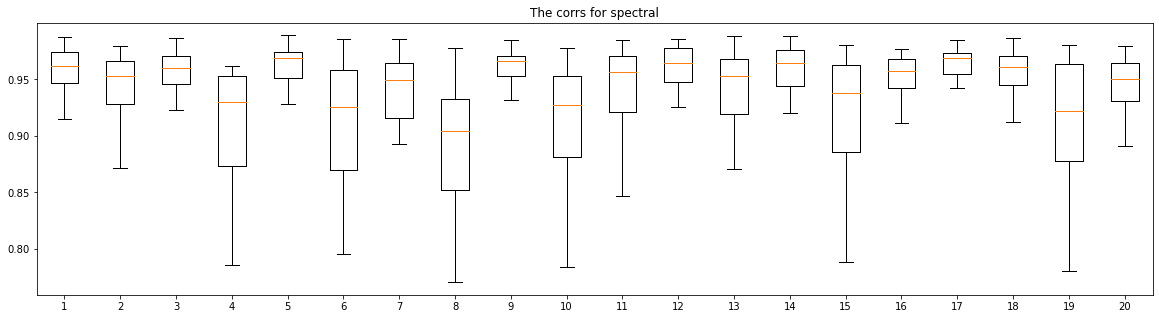

In [108]:
plt.figure(figsize=[20, 5])
plt.title("The corrs for spectral")
_ = plt.boxplot(np.array(PSDCorrss).T, showfliers=False)

In [111]:
SPCorrss = []
for ix in trange(20):
    with open(sortedFils[ix], "rb") as f:
        curRes = pickle.load(f)
    SPCorrs = []
    for mv, ov in zip(curRes.sgmSPs, MEGSPs):
        SPCorrs.append(mv.dot(ov))
        #SPCorrs.append(scipy.stats.pearsonr(mv, ov)[0])
    SPCorrss.append(np.array(SPCorrs))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.17it/s]


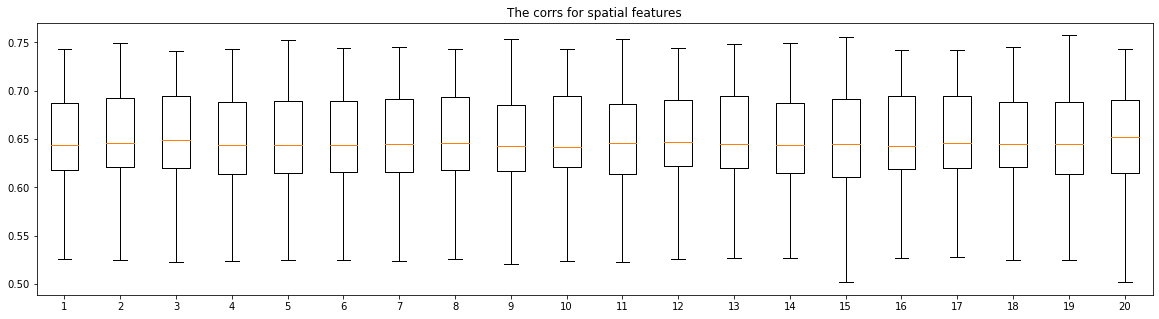

In [110]:
plt.figure(figsize=[20, 5])
plt.title("The corrs for spatial features")
_ = plt.boxplot(np.array(SPCorrss).T, showfliers=False)

### Results before

In [17]:
# taue, taui, tauC, speed, alpha, gii, gei
postSpssNp = np.array([i.numpy() for i in postSpss])
mEstParas = postSpssNp.mean(axis=1)
mEstParas = np.median(postSpssNp, axis=1)

In [18]:
modelPsdCurs = []
modelSpCurs = []
MEGSpCurs = []
MEGSpRawCurs = []
for ix in trange(len(mEstParas)):
    curParas = mEstParas[ix, :]
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    curSgmModel = sgm(curBrain.reducedConnectome, curBrain.distance_matrix, freqs)
    curPsd, curSP, _, _, _  = curSgmModel.run_local_coupling_forward(curParas)
    curPsd = curPsd[:68, :]
    curPsdCur = np.mean(stdPSDFn(mag2db(np.abs(curPsd))), axis=0)
    #curPsdCur = np.mean(mag2db(np.abs(curPsd)), axis=0)
    
    curMEGSp, curMEGSpRaw = MEGPSD2SF(curBrain.reducedConnectome, ind_psd[:, :, ix], freqs, is_More=True)
    modelPsdCurs.append(curPsdCur)
    modelSpCurs.append(curSP)
    MEGSpCurs.append(curMEGSp)
    MEGSpRawCurs.append(curMEGSpRaw)
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:41<00:00,  1.16s/it]


In [ ]:
expPsdCur = np.mean([stdPSDFn(mag2db(ind_psd[:, :, ix])).mean(axis=0) for ix in range(36)], axis=0)

In [ ]:
# get the posterior corrs for each subject
import multiprocessing as mp
def RunFn(ix):
#for ix in trange(len(mEstParas)):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    curSgmModel = sgm(curBrain.reducedConnectome, curBrain.distance_matrix, freqs)
    
    curMEGCur = np.mean(stdPSDFn(mag2db(np.abs(ind_psd[:, :, ix]))), axis=0)
    
    curPostSps = postSpssNp[ix, ::10, :]
    curCorrs = []
    for iy in trange(len(curPostSps)):
        curParas = curPostSps[iy, :]
        curPsd, curSP, _, _, _  = curSgmModel.run_local_coupling_forward(curParas)
        curPsdCur = np.mean(stdPSDFn(mag2db(np.abs(curPsd))), axis=0)
        #curPsdCur = np.mean(mag2db(np.abs(curPsd)), axis=0)
        curCorrs.append(scipy.stats.pearsonr(curPsdCur, curMEGCur)[0])
    

    return curCorrs

with mp.Pool(processes=20) as p:
    results = p.map(RunFn, np.arange(36))

In [25]:
#with open(paras.Path/f"./PostCorr_PriorNew_uni_{paras.numPriorSps:.0f}_sd{paras.noiseSd*100:.0f}.pkl", "wb") as f:
#    pickle.dump(results, f)

Text(0, 0.5, 'Correlations')

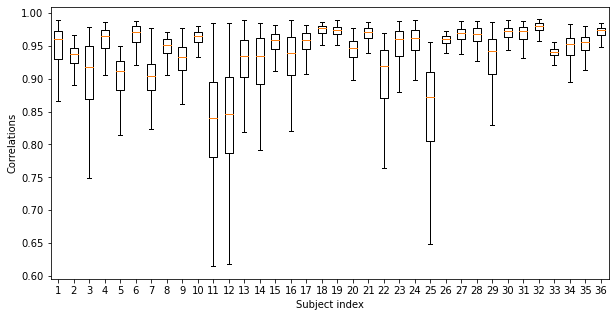

In [31]:
plt.figure(figsize=[10, 5])
_ = plt.boxplot(results, showfliers=False)
plt.xlabel("Subject index")
plt.ylabel("Correlations")

In [17]:
#with open(paras.Path/f"./PSDxSF_PriorNew_uni_{paras.numPriorSps:.0f}_sd{paras.noiseSd*100:.0f}.pkl", "wb") as f:
#    pickle.dump([modelPsdCurs, modelSpCurs], f)

In [19]:
modelPsdCur = np.mean(np.array(modelPsdCurs[:]), axis=0)
#expPsdCur =  np.mean(np.mean(mag2db(ind_psd), axis=0)[:, :].T, axis=0)
expPsdCur = np.mean([stdPSDFn(mag2db(ind_psd[:, :, ix])).mean(axis=0) for ix in range(36)], axis=0)

#ix = 5
#modelPsdCur = np.array(modelPsdCurs[ix])
#expPsdCur =  np.mean(mag2db(ind_psd), axis=0)[:, ix]

Text(0, 0.5, 'Normalized PSD')

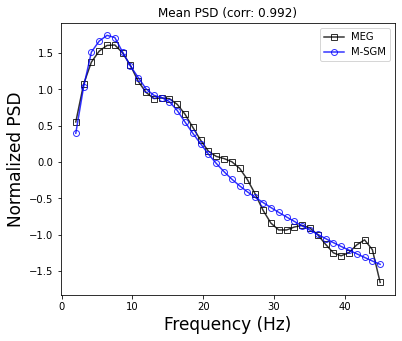

In [20]:
plt.figure(figsize=[6, 5])
cor = scipy.stats.pearsonr(stdFn(expPsdCur), stdFn(modelPsdCur))[0]
plt.title(f"Mean PSD (corr: {cor:.3f})")
plt.plot(freqs, stdFn(expPsdCur), linestyle = '-',marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
plt.plot(freqs, stdFn(modelPsdCur), linestyle = '-',marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.legend()
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)


In [21]:
MEG = np.mean(mag2db(ind_psd), axis=0).T
curSGM = np.array(modelPsdCurs)
corrs = []
for ix in range(MEG.shape[0]):
        curMEG = MEG[ix, :]
        curMod = curSGM[ix, :]
        corrs.append(scipy.stats.pearsonr(curMEG, curMod)[0])

0.9445231719986593 0.037718472622848435


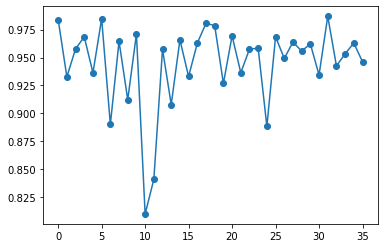

In [22]:
plt.plot(corrs, "-o")
print(np.mean(corrs), np.std(corrs))

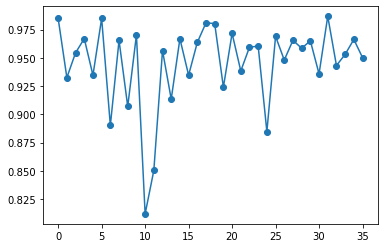

In [61]:
plt.plot(corrs, "-o")
print(np.mean(corrs), np.std(corrs))

In [65]:
spCorrs = []
for mv, ov in zip(modelSpCurs, MEGSpCurs):
    #spCorrs.append(mv.dot(ov))
    spCorrs.append(scipy.stats.pearsonr(mv, ov)[0])
    

#### Save for brain

In [51]:
rescaleFn = lambda x: (5-1)*(x-x.min())/(x.max()-x.min()) + 1
modelSpBrain = rescaleFn(np.mean(modelSpCurs, axis=0))
MEGSpBrain = rescaleFn(np.mean(MEGSpRawCurs, axis=0))

modelOut = U2BrainVec(reorderU(modelSpBrain))
MEGOut = U2BrainVec(reorderU(MEGSpBrain))

np.savetxt(paras.Path/f"Spatial_uni_model_Overall.txt", modelOut)
np.savetxt(paras.Path/f"Spatial_uni_MEG_Overall.txt", MEGOut)

In [56]:
modelSpBrain

array([2.97786973, 2.32894511, 3.04402502, 3.64778276, 3.12317836,
       2.14347537, 1.82658   , 2.10235811, 1.90075223, 2.2459907 ,
       1.83965188, 2.58250284, 1.76758699, 1.8859835 , 2.93871682,
       3.10003827, 2.37480991, 2.75468199, 2.08861872, 2.37605845,
       1.63606395, 1.83958261, 1.34077198, 1.41480306, 3.59166425,
       1.99290367, 1.32136762, 1.33388616, 1.28280888, 1.65035905,
       4.43471719, 1.9069387 , 4.89865384, 1.        , 3.11084136,
       2.32662956, 2.89675486, 3.7084497 , 3.01519483, 2.17203775,
       1.86013733, 2.17507132, 1.93561149, 2.24407679, 1.88788899,
       2.59599477, 1.68661805, 1.98298385, 2.87311045, 3.01693331,
       2.38343158, 2.79414491, 2.08859487, 2.45163483, 1.73929757,
       1.84837141, 1.33080743, 1.40990698, 3.51949394, 1.96515322,
       1.37223101, 1.32558133, 1.24128131, 1.62705039, 4.34303725,
       1.96850693, 5.        , 1.04184079])

###  Results for Each Bay SGM

In [33]:
for ix in range(5, ind_conn.shape[-1]):
    print(ix)
    
    # obtain the brain
    curC = ind_conn[:, :, ix]
    data_dir = path.get_data_path()
    brain = Brain.Brain()
    brain.add_connectome(data_dir)
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome = curC
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    sgmmodel = sgm(brain.reducedConnectome, brain.distance_matrix, freqs)
    
    # taue, taui, tauC, speed, alpha, gii, gei
    prior = utils.BoxUniform(low=torch.as_tensor(par_low), high=torch.as_tensor(par_high))
    # make a SBI-wrapper on the simulator object for compatibility
    simulator_wrapper, prior = prepare_for_sbi(simulator, prior)
    
    theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=paras.numPriorSps, num_workers=20)
    
    with open(paras.Path/f"./PriorNew_each_{paras.numPriorSps:.0f}_sd{paras.noiseSd*100:.0f}_{ix}.pkl", "wb") as f:
        pickle.dump([theta, x], f)
        
    inference = SNPE(prior=prior, density_estimator="mdn")
    density_estimator = inference.append_simulations(theta, x).train()
    
    posterior = inference.build_posterior(density_estimator)
    
    
    sp = MEGPSD2SF(brain.reducedConnectome, ind_psd[:, :, ix], freqs, band="alpha")
    stdSp = stdFn(sp)
    #stdPsd = stdPSDFn(mag2db(ind_psd[:, :, ix])).flatten()
    #curX = torch.Tensor(np.concatenate([stdPsd.flatten(), stdSp]))
    stdPsd = stdPSDFn(mag2db(ind_psd[:, :, ix])).mean(axis=0)
    curX = torch.Tensor(np.concatenate([stdPsd, stdSp]))
    postSps = posterior.sample((10000, ), x=curX)
    
    with open(paras.Path/f"./PostSp_PriorNew_each_{paras.numPriorSps:.0f}_sd{paras.noiseSd*100:.0f}_{ix}.pkl", "wb") as f:
        pickle.dump(postSps, f)

5


Running 100000 simulations in 100000 batches.:   0%|          | 0/100000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 Neural network successfully converged after 283 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 10000 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


KeyboardInterrupt: 

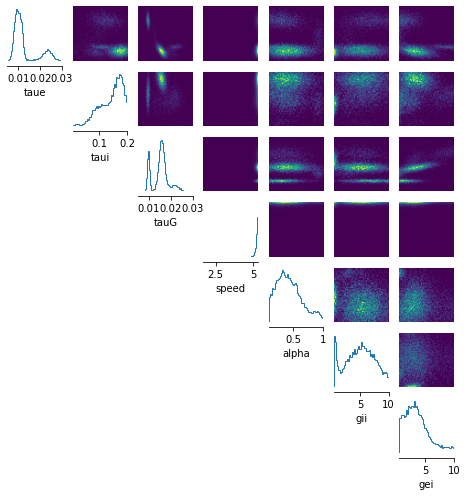

In [24]:
plotLimits = np.array([par_low, par_high]).T
_ = analysis.pairplot(postSps, limits=plotLimits, labels=['taue','taui','tauG','speed','alpha','gii','gei'], figsize=(8,8))

#### Reults

In [11]:
retIndFn = lambda fil:int(fil.stem.split("_")[-1])
fils = list(paras.Path.glob("PostSp_*sd40*"))
fils = sorted(fils, key=retIndFn)

In [12]:
modelPsdCurs = []
modelSpCurs = []
MEGSpCurs = []
MEGPsdCurs = []

for fil in fils[:]:
    with open(fil, "rb") as f:
        curSps = pickle.load(f)
    ix = int(fil.stem.split("_")[-1])
    curParas = np.median(curSps, axis=0)
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    curSgmModel = sgm(curBrain.reducedConnectome, curBrain.distance_matrix, freqs)
    curPsd, curSP, _, _, _  = curSgmModel.run_local_coupling_forward(curParas)
    
    curPsd = curPsd[:68, :]
    curPsdCur = np.mean(stdPSDFn(mag2db(np.abs(curPsd))), axis=0)
    curMEGSp = MEGPSD2SF(curBrain.reducedConnectome, ind_psd[:, :, ix], freqs)
    curMEGPsd = mag2db(ind_psd[:, :, ix]).mean(axis=0)
    
    modelSpCurs.append(curSP)
    modelPsdCurs.append(curPsdCur)
    MEGSpCurs.append(curMEGSp)
    MEGPsdCurs.append(curMEGPsd)

In [13]:
MEGPsdM = np.array(MEGPsdCurs).mean(axis=0)
modelPsdM = np.array(modelPsdCurs).mean(axis=0)

Text(0, 0.5, 'Normalized PSD')

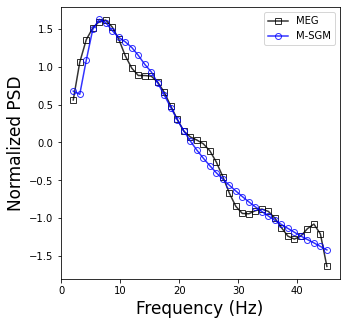

In [14]:
plt.figure(figsize=[5, 5])
#plt.plot(freqs, stdFn(curMEGPsd), linestyle = '-',marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
#plt.plot(freqs, stdFn(curPsdCur), linestyle = '-',marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.plot(freqs, stdFn(MEGPsdM), linestyle = '-',marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
plt.plot(freqs, stdFn(modelPsdM), linestyle = '-',marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.legend()
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)

In [15]:
corrs = []
for ix, iy in zip(modelPsdCurs, MEGPsdCurs):
    corrs.append(scipy.stats.pearsonr(ix, iy)[0])

In [16]:
print(np.mean(corrs), np.std(corrs))

0.929123674022548 0.05554641950562407


In [19]:
spCorrs = []
for mv, ov in zip(modelSpCurs, MEGSpCurs):
    spCorrs.append(mv.dot(ov))
    #spCorrs.append(scipy.stats.pearsonr(mv, ov)[0])
    

In [22]:
ix = 0
for mv, ov in zip(modelSpCurs, MEGSpCurs):
    mvMM, ovMM = minmaxFn(mv), minmaxFn(ov)
    mvOut = U2BrainVec(reorderU(mvMM))
    ovOut = U2BrainVec(reorderU(ovMM))
    np.savetxt(paras.Path/f"Spatial_each_model_{ix}.txt", mvOut)
    np.savetxt(paras.Path/f"Spatial_each_MEG_{ix}.txt", ovOut)
    ix += 1
    

In [41]:
rescaleFn = lambda x: (5-1)*(x-x.min())/(x.max()-x.min()) + 1
modelSpBrain = rescaleFn(np.mean(modelSpCurs, axis=0))
MEGSpBrain = rescaleFn(np.mean(MEGSpCurs, axis=0))

modelOut = U2BrainVec(reorderU(modelSpBrain))
MEGOut = U2BrainVec(reorderU(MEGSpBrain))

np.savetxt(paras.Path/f"Spatial_each_model_Overall.txt", modelOut)
np.savetxt(paras.Path/f"Spatial_each_MEG_Overall.txt", MEGOut)